In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim 
import torchvision 
import torchvision.transforms as transforms
from datetime import datetime
import pandas as pd
import optuna
import os
from os.path import join
import timeit
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix
from torch.utils.tensorboard import SummaryWriter
torch.cuda.is_available() 
from sklearn.metrics import roc_auc_score
#from tqdm.notebook import tqdm
from tqdm.auto import tqdm
import time

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def bce(y_preds, y_true, epsilon=np.finfo(np.float32).eps):
    return - (1-y_true)* torch.log(1-y_preds+epsilon) - y_true * torch.log(y_preds+epsilon)

In [4]:
def data_loader(data="train", directory=join(os.getcwd(),'NormalizedData.h5')):
    # Data types = train, validate, test
    print("[+] Loading Data..")
    tic=timeit.default_timer()

    df = pd.read_hdf(
                    directory,
                    key=data,
                    )
    
    toc=timeit.default_timer()
    print("[+] Data Loaded in", int(toc-tic), "seconds!")

    return df

In [5]:
def create_batch(df, size=200, debug=False):
    # Data types = train, validate, test

    if debug:
        print("[Info] Len(data) =", len(df))
        print("[Info] Len(data) / Batch Size =", len(df)/size)

    # Select the data size
    # TODO: Estou a perder um pouco de dados no final
    batch = iter([
            # Big tuple
            (
                i+1, # Batch number
                torch.tensor(df.iloc[x:x+size].drop(columns=['index','Name', 'Weights', 'Label']).values, dtype=torch.float32).to(device), # Features Removi MissingET_Eta porque tava cheio de NaA (???)
                torch.tensor(df['Label'].iloc[x:x+size].values, dtype=torch.float32).to(device),

                torch.tensor((
                np.where(
                    df['Label'].iloc[x:x+size] == 0,
                    df['Weights'].iloc[x:x+size] / df['Weights'].iloc[x:x+size][df['Label'].iloc[x:x+size] == 0].sum(),
                    df['Weights'].iloc[x:x+size] / df['Weights'].iloc[x:x+size][df['Label'].iloc[x:x+size] == 1].sum(),
                )
                * df['Label'].iloc[x:x+size].shape[0]
                / 2
                ), dtype=torch.float32).to(device),
                df.iloc[x:x+size]['Name'] #Nome
        ) 
        
         for i,x in enumerate(list(filter(lambda x: (x%(size+1) == 0) , [x for x in range(len(df))])))]) # Para size = 100 -> 0, 101, 202, 303, .. , 909, 1010, 1111


    del df

    return batch

In [6]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

# Training Loop

## Optuna Stuff

In [7]:
## LOAD DATA

#batch_number, features, target, weights, name 
train_data = data_loader(data='train')
val_data = data_loader(data='validate')

# Validation data prep.
_, val_features, val_label, val_weights, _ = next(create_batch(val_data, size=val_data.shape[0]))
del val_data


[+] Loading Data..
[+] Data Loaded in 7 seconds!
[+] Loading Data..
[+] Data Loaded in 8 seconds!


In [8]:
def define_model(trial):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 1, 50)
    layers = []

    in_features = 68
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 5, 200)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        p = trial.suggest_float("dropout_l{}".format(i), 0.1, 0.5)
        layers.append(nn.Dropout(p))

        in_features = out_features

    # Ultima layer
    layers.append(nn.Linear(in_features, 1))
    layers.append(nn.Sigmoid())

    return nn.Sequential(*layers)

In [9]:
name=datetime.now().strftime("%d-%m-%Y_%H-%M-%S")

def objective(trial):
    print("[+] Starting training..\n")
    
    # Optuna Stuff
    model = define_model(trial).to(device)
    optimizer_name = trial.suggest_categorical("optimizer", ["SGD", "RMSprop", "AdamW"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    epochs = trial.suggest_int("n_epochs", 5, 100)
    batch_size = trial.suggest_int("batch_size", 100, 1000)
    early_stoping = trial.suggest_int("batch_size", 1, 15)

    # For early stopping
    patience_count = 0
    best_roc = 0
    
    tic=timeit.default_timer()

    for epoch in tqdm(range(epochs)):
        model.train()

        for batch in create_batch(train_data, size=batch_size):
            # batch -> (batch_number, Features, Label, Weights, Nome)

            preds = model(batch[1]) # Passar a batch pela network

            ## Loss
            loss = bce(preds.squeeze(1), batch[2])
            loss = (batch[3] * loss) / batch[3].sum()
            loss = torch.mean(loss, dtype=torch.float32)


            optimizer.zero_grad() # Resetar gradientes
            loss.backward() # Calcular os gradientes
            optimizer.step()


        # No final de cada epoca calcular o rocauc da validation para o optuna
        model.eval()
        with torch.no_grad():
            ROC_SCORE = roc_auc_score(val_label.cpu() , model(val_features).squeeze(1).cpu(), sample_weight=val_weights.cpu())
        trial.report(ROC_SCORE, epoch)

        # Ver se guarda o melhor model
        if ROC_SCORE > best_roc:
            #name = ""
            #for key, value in trial.params.items():
            #    name += "{}_{}_".format(key, int(value))
            name = str(ROC_SCORE) + ".model"
            best_roc = ROC_SCORE
            
            torch.save(model.state_dict(), join(os.getcwd(),"models_optuna",name))
            # Reset patience_count for early stop 
            patience_count = 0
        else:
            patience_count += 1

    # Final do treino
    toc=timeit.default_timer()

    print("\n[+] Training completed in", int((toc-tic)/60), "minutes!")
    return best_roc


In [10]:
    study = optuna.create_study(study_name="Optimizing The Neural Network",direction="maximize", storage="sqlite:///example.db")
    study.optimize(objective, n_trials=50)

    pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
    complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

er': 'AdamW', 'lr': 0.06941862262406515, 'n_epochs': 33, 'batch_size': 679}. Best is trial 6 with value: 0.9672167229471519.

[+] Training completed in 4 minutes!
[+] Starting training..

100%|██████████| 99/99 [2:29:46<00:00, 90.77s/it]
[I 2021-02-17 05:46:04,803] Trial 11 finished with value: 0.9618489594600244 and parameters: {'n_layers': 14, 'n_units_l0': 191, 'dropout_l0': 0.23505313894196497, 'n_units_l1': 19, 'dropout_l1': 0.2734547605698957, 'n_units_l2': 199, 'dropout_l2': 0.12550077390772285, 'n_units_l3': 5, 'dropout_l3': 0.2638709504075912, 'n_units_l4': 6, 'dropout_l4': 0.11628730828519157, 'n_units_l5': 184, 'dropout_l5': 0.44618186436228946, 'n_units_l6': 71, 'dropout_l6': 0.49834520118236975, 'n_units_l7': 196, 'dropout_l7': 0.40376061192386786, 'n_units_l8': 5, 'dropout_l8': 0.34901476611609683, 'n_units_l9': 198, 'dropout_l9': 0.10438578195505474, 'n_units_l10': 9, 'dropout_l10': 0.3981512408739467, 'n_units_l11': 12, 'dropout_l11': 0.49069818288339406, 'n_units_l12':

KeyboardInterrupt: 

In [11]:
trial = study.best_trial

In [12]:
import joblib
joblib.dump(study, "study.pkl")

['study.pkl']

# Optuna graphs

In [13]:
import joblib
study = joblib.load("study.pkl")

In [14]:
optuna.visualization.plot_param_importances(study)

In [16]:
optuna.visualization.plot_intermediate_values(study)

In [17]:
optuna.visualization.plot_optimization_history(study)

In [18]:
optuna.visualization.plot_parallel_coordinate(study)

# Testing the model out

In [19]:
device = device = torch.device('cpu')
torch.set_grad_enabled(False)

In [20]:

trial = study.best_trial

# Make the model with the best parameters found
model = define_model(trial)

In [22]:
""" name = ""
for key, value in trial.params.items():
    name += "{}_{}hhhsi9iu9_".format(key, value) """
name = str(trial.value) + ".model"

# Load the already trained model
model.load_state_dict(torch.load(join(os.getcwd(),"models_optuna",name)))

<All keys matched successfully>

In [23]:
model.eval()

Sequential(
  (0): Linear(in_features=68, out_features=121, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.24951969108997804, inplace=False)
  (3): Linear(in_features=121, out_features=164, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.4164702772706052, inplace=False)
  (6): Linear(in_features=164, out_features=130, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.34382459231190765, inplace=False)
  (9): Linear(in_features=130, out_features=103, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.32336653192587167, inplace=False)
  (12): Linear(in_features=103, out_features=113, bias=True)
  (13): ReLU()
  (14): Dropout(p=0.21536700411323847, inplace=False)
  (15): Linear(in_features=113, out_features=61, bias=True)
  (16): ReLU()
  (17): Dropout(p=0.2715282451544035, inplace=False)
  (18): Linear(in_features=61, out_features=107, bias=True)
  (19): ReLU()
  (20): Dropout(p=0.17820887026727894, inplace=False)
  (21): Linear(in_features=107, out_features=43, bias=True)
  (22): ReLU()
  (23): Dropout(p=

### Load Test Data

In [24]:
test_data = data_loader(data="test").drop(columns=['index'])
test_data.describe()

[+] Loading Data..
[+] Data Loaded in 8 seconds!


,Jet_Multi,Jet1_Mass,Jet1_Eta,Jet1_Phi,Jet1_PT,Jet1_BTag,Jet2_Mass,Jet2_Eta,Jet2_Phi,Jet2_PT,...,Muon1_Phi,Muon1_PT,Muon2_Eta,Muon2_Phi,Muon2_PT,MissingET_MET,MissingET_Phi,ScalarHT_HT,Label,Weights
count,1.509872e+06,1.509872e+06,1.509872e+06,1.509872e+06,1.509872e+06,1.509872e+06,1.509872e+06,1.509872e+06,1.509872e+06,1.509872e+06,...,1.509872e+06,1.509872e+06,1.509872e+06,1.509872e+06,1.509872e+06,1.509872e+06,1.509872e+06,1.509872e+06,1.509872e+06,1.509872e+06
mean,-4.403962e-04,-3.169950e-04,1.919765e-03,-7.500912e-04,-2.182479e-03,-2.956233e-04,-1.920912e-03,-1.473976e-04,5.886514e-05,-1.119410e-03,...,1.310890e-03,-3.390498e-03,1.056866e-03,2.244645e-04,-2.551370e-03,-9.862976e-04,-5.075757e-04,-1.545192e-03,4.409513e-02,7.772088e-06
std,9.997421e-01,9.999649e-01,1.001273e+00,9.997466e-01,9.951093e-01,1.000060e+00,9.988197e-01,9.996049e-01,1.000510e+00,9.982385e-01,...,9.998913e-01,9.984771e-01,9.992862e-01,9.994316e-01,9.930162e-01,9.968513e-01,9.988965e-01,9.976698e-01,2.053065e-01,1.400269e-05
min,-1.649581e+00,-1.384238e+00,-3.538465e+00,-1.732104e+00,-1.227972e+00,-1.222218e+00,-1.458502e+00,-3.168550e+00,-1.795324e+00,-1.484852e+00,...,-1.999019e+00,-9.487765e-01,-3.067431e+00,-2.619935e+00,-6.540112e-01,-1.136653e+00,-1.731221e+00,-1.597308e+00,0.000000e+00,1.286454e-09
25%,-1.024832e+00,-5.923256e-01,-6.987161e-01,-8.670166e-01,-6.325989e-01,-1.222218e+00,-5.621344e-01,-6.583196e-01,-8.318531e-01,-6.321707e-01,...,-6.643602e-01,-9.487765e-01,6.259453e-04,2.053101e-04,-6.540112e-01,-7.578464e-01,-8.644043e-01,-6.779826e-01,0.000000e+00,1.811693e-07
50%,-4.000820e-01,-2.591055e-01,1.524748e-03,-1.526841e-03,-2.186928e-01,8.181844e-01,-1.839713e-01,-5.016521e-04,1.541433e-04,-1.812021e-01,...,7.188655e-04,-1.115985e-01,6.259453e-04,2.053101e-04,-6.540112e-01,-2.311350e-01,-1.250374e-03,-2.020433e-01,0.000000e+00,5.028781e-06
75%,8.494175e-01,2.696276e-01,7.022158e-01,8.662250e-01,3.497483e-01,8.181844e-01,3.662726e-01,6.576045e-01,8.318921e-01,4.305953e-01,...,6.678170e-01,3.632169e-01,6.259453e-04,2.053101e-04,5.261358e-01,4.865845e-01,8.641697e-01,4.270109e-01,0.000000e+00,7.089469e-06
max,7.096915e+00,4.129075e+01,3.513001e+00,1.731554e+00,3.008994e+01,8.181844e-01,3.596933e+01,3.166699e+00,1.795633e+00,3.140511e+01,...,2.000454e+00,3.957771e+01,3.068657e+00,2.620328e+00,3.332523e+01,3.837758e+01,1.731338e+00,2.017072e+01,1.000000e+00,8.083906e-05


In [25]:
test_label = torch.tensor(test_data['Label'].values, dtype=torch.float32).to(device)
test_predictions = model(torch.tensor(test_data.drop(columns=['Label', 'Weights', 'Name']).values, dtype=torch.float32)).to(device)

In [26]:
confusion_matrix(test_predictions.round(), test_label)

array([[1385393,   10052],
       [  57901,   56526]])

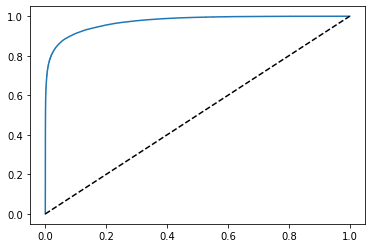

In [27]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# fpr = False positive rate
# tpr = True positive rate
fpr, tpr, thr = roc_curve(test_label , test_predictions, sample_weight=test_data["Weights"])
plt.plot(fpr, tpr, label='ROC')
plt.plot([0,1],[0,1], 'k--')
plt.show()

In [28]:
from sklearn.metrics import roc_auc_score

roc_auc_score(test_label , test_predictions, sample_weight=test_data["Weights"])

0.9716960011038662